Notebook exploring different observables and how they vary for different dust models of increasing complexity


**Notes**
- Balmer ratio abandoned as observable because of general instability and replaced with $g-r$ color

In [1]:
import os 
import h5py
import numpy as np 
import corner as DFM 
# -- galpopfm --
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
dat_dir = os.environ['GALPOPFM_DIR']

In [3]:
# don't touch these values!
nbins = [8, 10, 11]
ranges = [(20, 24), (-0.5, 2.), (-2, 9.)]
dRmag   = 0.5 
dGR     = 0.25
dfuvnuv = 1.

In [4]:
# read in SDSS observables 
fsdss = os.path.join(dat_dir, 'obs', 'tinker_SDSS_centrals_M9.7.valueadd.hdf5') 
sdss = h5py.File(fsdss, 'r') 

mr_complete = (sdss['mr_tinker'][...] < -20.) 

z_sdss = sdss['redshift_tinker'][...][mr_complete]/299792.458

Fmag    = sdss['ABSMAG'][...][:,0][mr_complete]
Nmag    = sdss['ABSMAG'][...][:,1][mr_complete]
Rmag    = sdss['mr_tinker'][...][mr_complete]
Gmag    = sdss['mg_tinker'][...][mr_complete]
Haflux  = sdss['HAFLUX'][...][mr_complete]
Hbflux  = sdss['HBFLUX'][...][mr_complete]

FUV_NUV =  Fmag - Nmag
G_R = Gmag - Rmag

balmer_ratio = Haflux / Hbflux
balmer = np.log10(balmer_ratio/2.86)
print('%f < balmer < %f' % (balmer[~np.isnan(balmer)].min(), balmer[~np.isnan(balmer)].max()))
print('%f < G - R < %f' % (G_R.min(), G_R.max()))
print('%f < FUV-NUV < %f' % (FUV_NUV.min(), FUV_NUV.max()))

zmax = z_sdss.max()
zmin = z_sdss.min() 
print('%f < z_sdss < %f' % (zmin, zmax))

from astropy.cosmology import Planck13 as cosmo
vol_sdss = (cosmo.comoving_volume(zmax).value - cosmo.comoving_volume(zmin).value) * (7966./41253.) * cosmo.h**3 # (Mpc/h)^3

-2.219882 < balmer < 2.707833
0.280000 < G - R < 1.430000
-8.913282 < FUV-NUV < 26.203045
0.010707 < z_sdss < 0.033390


In [5]:
#data_vector = np.array([-1.*Rmag, balmer, FUV_NUV]).T
data_vector = np.array([-1.*Rmag, G_R, FUV_NUV]).T

Nbins, edges = np.histogramdd(data_vector, bins=nbins, range=ranges)
x_obs = Nbins.astype(float) / vol_sdss / dRmag / dGR / dfuvnuv
Rmag_edges = edges[0] 
GR_edges = edges[1]
fuvnuv_edges = edges[2]

read in SIMBA and TNG SEDs

In [6]:
# read in SIMBA
_sim_sed = dustInfer._read_sed('simba') 
wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
downsample = np.zeros(len(_sim_sed['logmstar'])).astype(bool)
downsample[::10] = True
f_downsample = 0.1

cens = _sim_sed['censat'].astype(bool) & (_sim_sed['logmstar'] > 9.4) & downsample

sim_sed = {} 
sim_sed['sim']          = 'simba'
sim_sed['logmstar']     = _sim_sed['logmstar'][cens].copy()
sim_sed['logsfr.100']   = _sim_sed['logsfr.100'][cens].copy() 
sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
sim_sed['sed']    = _sim_sed['sed_neb'][cens,:][:,wlim].copy() 
sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cens,:][:,wlim].copy() 
sim_sed['sed_onlyneb']    = _sim_sed['sed_onlyneb'][cens,:][:,wlim].copy() 

# read in TNG
_tng_sed = dustInfer._read_sed('tng') 
wlim = (_tng_sed['wave'] > 1e3) & (_tng_sed['wave'] < 8e3) 
downsample = np.zeros(len(_tng_sed['logmstar'])).astype(bool)
downsample[::10] = True

cens = _tng_sed['censat'].astype(bool) & (_tng_sed['logmstar'] > 9.4) & downsample

tng_sed = {} 
tng_sed['sim']          = 'tng'
tng_sed['logmstar']     = _tng_sed['logmstar'][cens].copy()
tng_sed['logsfr.100']   = _tng_sed['logsfr.100'][cens].copy() 
tng_sed['wave']         = _tng_sed['wave'][wlim].copy()
tng_sed['sed']    = _tng_sed['sed_neb'][cens,:][:,wlim].copy() 
tng_sed['sed_noneb']    = _tng_sed['sed_noneb'][cens,:][:,wlim].copy() 
tng_sed['sed_onlyneb']    = _tng_sed['sed_onlyneb'][cens,:][:,wlim].copy() 

In [7]:
def sim_observables_AV(A_V, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()
        
    T_lam = 10.0**(-0.4 * A_V * dustFM.calzetti_absorption(sed['wave']))
    sed_dusty = sed['sed'] * T_lam

    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    G_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='g_sdss') 
    FUV_NUV = F_mag - N_mag 
    print('%f < FUV_NUV < %f' % (FUV_NUV.min(), FUV_NUV.max()))
    
    G_R = G_mag - R_mag
    print('%f < G-R < %f' % (G_R.min(), G_R.max()))

    data_vector = np.array([-1.*R_mag, G_R, FUV_NUV]).T
    Nbins, _ = np.histogramdd(data_vector, bins=nbins, range=ranges)
    
    # volume of simulation 
    vol = {'simba': 100.**3, 'tng': 75.**3}[sim]  

    x_model = Nbins.astype(float) / vol / dRmag / dGR / dfuvnuv
    return x_model

Try directly changing A_V

-0.084457 < FUV_NUV < 3.778920
-0.032477 < G-R < 0.782425
0.324640 < FUV_NUV < 4.224691
0.213087 < G-R < 1.009106
0.739199 < FUV_NUV < 4.671816
0.455235 < G-R < 1.233114


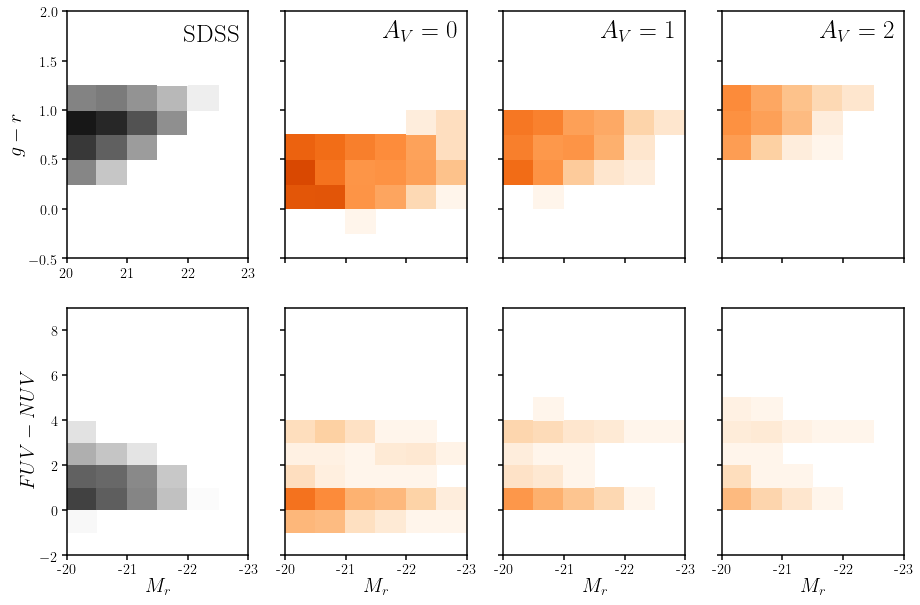

In [8]:
avs = [0., 1., 2.]
fig = plt.figure(figsize=(15,10))

sub = fig.add_subplot(241)
sub.pcolormesh(Rmag_edges, GR_edges, 0.5 * np.sum(x_obs, axis=2).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.text(0.95, 0.95, r'SDSS', ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_ylabel(r'$g - r$', fontsize=20) 
#sub.set_ylabel(r'$\log (H_\alpha/H_\beta)/(H_\alpha/H_\beta)_I$', fontsize=20) 
sub.set_ylim(ranges[1]) 

sub = fig.add_subplot(245)
sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_obs, axis=1).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(ranges[2]) 

for i, av in enumerate(avs):
    sub = fig.add_subplot(2,4,i+2)
    x_mod = sim_observables_AV(av, sim='simba')
    sub.pcolormesh(Rmag_edges, GR_edges, dfuvnuv * np.sum(x_mod, axis=2).T, 
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.text(0.95, 0.95, r'$A_V=%.f$' % av, ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_ylim(ranges[1]) 

    sub = fig.add_subplot(2,4,i+6)
    sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_mod, axis=1).T,
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.set_xlabel(r'$M_r$', fontsize=20) 
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    sub.set_ylim(ranges[2]) 
    sub.set_yticklabels([])

Now lets try changing tau_V

In [9]:
def sim_observables_tauV(tauV, sim='simba'): 
    ''' slab model with varying optical depth
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()

    sed_dusty = dustFM.Attenuate(
        np.array([0., tauV, 1.]), 
        sed['wave'], 
        sed['sed_noneb'], 
        sed['sed_onlyneb'], 
        sed['logmstar'],
        sed['logsfr.100'],
        dem='slab_calzetti') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    G_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='g_sdss') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    
    FUV_NUV = F_mag - N_mag 
    print('%f < FUV_NUV < %f' % (FUV_NUV.min(), FUV_NUV.max()))
    
    G_R = G_mag - R_mag
    print('%f < G-R < %f' % (G_R.min(), G_R.max()))

    data_vector = np.array([-1.*R_mag, G_R, FUV_NUV]).T
    Nbins, _ = np.histogramdd(data_vector, bins=nbins, range=ranges)
    
    # volume of simulation 
    vol = {'simba': 100.**3, 'tng': 75.**3}[sim]  

    x_model = Nbins.astype(float) / vol / dRmag / dGR / dfuvnuv
    return x_model

-0.043798 < FUV_NUV < 3.823428
-0.007762 < G-R < 0.805218
0.144548 < FUV_NUV < 5.512687
0.209736 < G-R < 2.430671
0.564243 < FUV_NUV < 6.113761
0.446497 < G-R < 2.181169


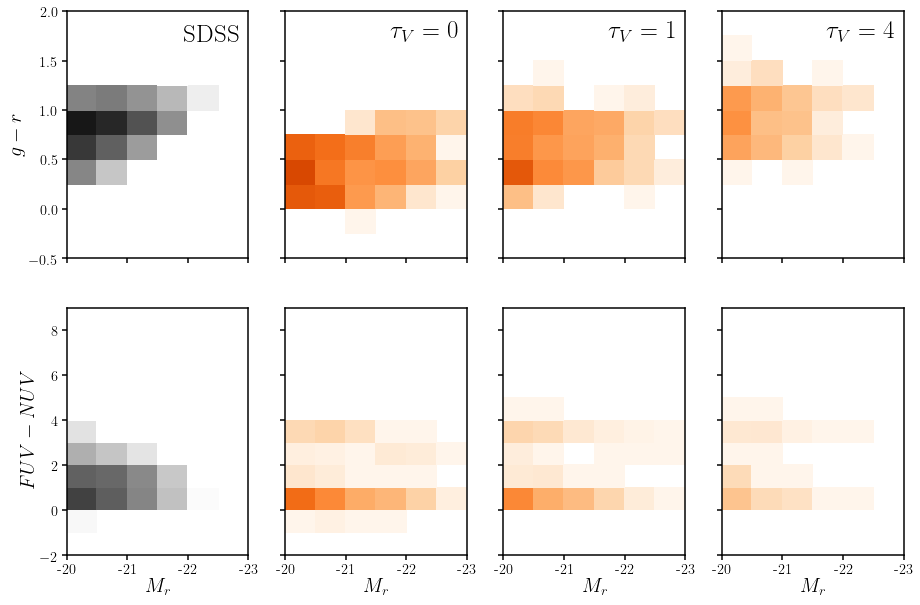

In [10]:
tauvs = [0.0, 1., 4.]
fig = plt.figure(figsize=(15,10))

sub = fig.add_subplot(241)
sub.pcolormesh(Rmag_edges, GR_edges, 0.5 * np.sum(x_obs, axis=2).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.text(0.95, 0.95, r'SDSS', ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([])
sub.set_ylabel(r'$g - r$', fontsize=20) 
#sub.set_ylabel(r'$\log (H_\alpha/H_\beta)/(H_\alpha/H_\beta)_I$', fontsize=20) 
sub.set_ylim(ranges[1]) 

sub = fig.add_subplot(245)
sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_obs, axis=1).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(ranges[2]) 

for i, tauv in enumerate(tauvs):
    sub = fig.add_subplot(2,4,i+2)
    x_mod = sim_observables_tauV(tauv, sim='simba')
    sub.pcolormesh(Rmag_edges, GR_edges, dfuvnuv * np.sum(x_mod, axis=2).T, 
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.text(0.95, 0.95, r'$\tau_V=%.f$' % tauv, ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_ylim(ranges[1]) 

    sub = fig.add_subplot(2,4,i+6)
    sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_mod, axis=1).T,
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.set_xlabel(r'$M_r$', fontsize=20) 
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    sub.set_ylim(ranges[2]) 
    sub.set_yticklabels([])

In [11]:
def sim_observables_tauV_delta(tauV, delta, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()
        
    #m_tau c_tau m_delta c_delta m_E c_E fneb
    sed_dusty = dustFM.Attenuate(
        np.array([0., tauV, 0., delta, 0., 0., 1.]), 
        sed['wave'], 
        sed['sed_noneb'], 
        sed['sed_onlyneb'], 
        sed['logmstar'],
        sed['logsfr.100'],
        dem='slab_noll_m') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    G_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='g_sdss') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    
    FUV_NUV = F_mag - N_mag 
    print('%f < FUV_NUV < %f' % (FUV_NUV.min(), FUV_NUV.max()))
    
    G_R = G_mag - R_mag
    print('%f < G-R < %f' % (G_R.min(), G_R.max()))

    data_vector = np.array([-1.*R_mag, G_R, FUV_NUV]).T
    Nbins, _ = np.histogramdd(data_vector, bins=nbins, range=ranges)
    
    # volume of simulation 
    vol = {'simba': 100.**3, 'tng': 75.**3}[sim]  

    x_model = Nbins.astype(float) / vol / dRmag / dGR / dfuvnuv
    return x_model

0.128909 < FUV_NUV < 4.833719
0.095484 < G-R < 2.228547
-0.727145 < FUV_NUV < 3.678808
-0.515674 < G-R < 0.668620
-0.252740 < FUV_NUV < 3.752803
-3.157609 < G-R < 0.463745


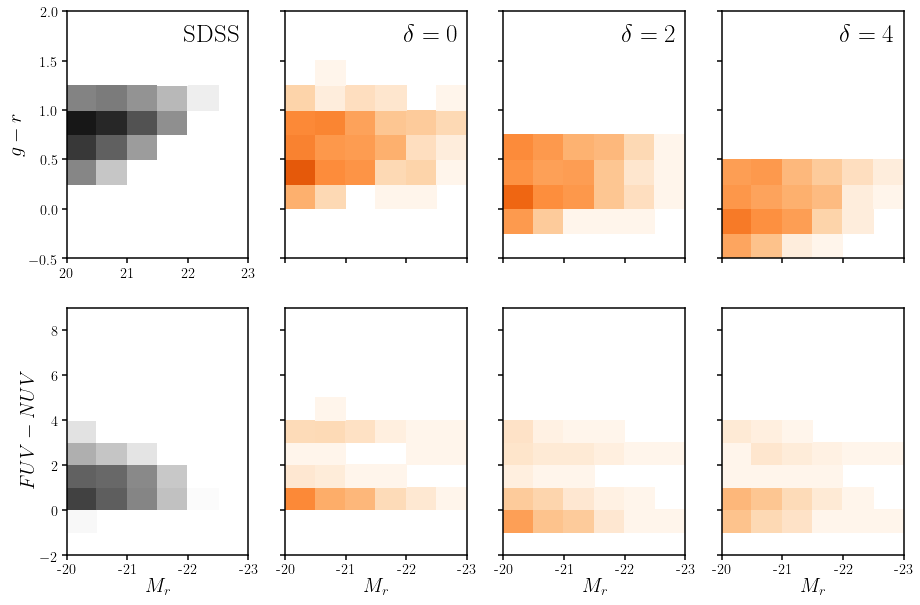

In [12]:
deltas = [0., 2., 4.]
fig = plt.figure(figsize=(15,10))

sub = fig.add_subplot(241)
sub.pcolormesh(Rmag_edges, GR_edges, 0.5 * np.sum(x_obs, axis=2).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.text(0.95, 0.95, r'SDSS', ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_ylabel(r'$g - r$', fontsize=20) 
#sub.set_ylabel(r'$\log (H_\alpha/H_\beta)/(H_\alpha/H_\beta)_I$', fontsize=20) 
sub.set_ylim(ranges[1]) 

sub = fig.add_subplot(245)
sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_obs, axis=1).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(ranges[2]) 

for i, delta in enumerate(deltas):
    sub = fig.add_subplot(2,4,i+2)
    x_mod = sim_observables_tauV_delta(1., delta, sim='simba')
    sub.pcolormesh(Rmag_edges, GR_edges, dfuvnuv * np.sum(x_mod, axis=2).T, 
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.text(0.95, 0.95, r'$\delta=%.f$' % delta, ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_ylim(ranges[1]) 

    sub = fig.add_subplot(2,4,i+6)
    sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_mod, axis=1).T,
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.set_xlabel(r'$M_r$', fontsize=20) 
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    sub.set_ylim(ranges[2]) 
    sub.set_yticklabels([])

In [13]:
def sim_observables_tauV_delta_fneb(tauV, delta, fneb, sim='simba'): 
    '''
    '''
    if sim == 'simba': 
        sed = sim_sed.copy()
    elif sim == 'tng': 
        sed = tng_sed.copy()
        
    #m_tau c_tau m_delta c_delta m_E c_E fneb
    sed_dusty = dustFM.Attenuate(
        np.array([0., tauV, 0., delta, 0., 0., fneb]), 
        sed['wave'], 
        sed['sed_noneb'], 
        sed['sed_onlyneb'], 
        sed['logmstar'],
        sed['logsfr.100'],
        dem='slab_noll_m') 
   
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    G_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='g_sdss') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 
    
    FUV_NUV = F_mag - N_mag 
    print('%f < FUV_NUV < %f' % (FUV_NUV.min(), FUV_NUV.max()))
    
    G_R = G_mag - R_mag
    print('%f < G-R < %f' % (G_R.min(), G_R.max()))

    data_vector = np.array([-1.*R_mag, G_R, FUV_NUV]).T
    Nbins, _ = np.histogramdd(data_vector, bins=nbins, range=ranges)
    
    # volume of simulation 
    vol = {'simba': 100.**3, 'tng': 75.**3}[sim]  

    x_model = Nbins.astype(float) / vol / dRmag / dGR / dfuvnuv
    return x_model

-0.470643 < FUV_NUV < 3.707591
-0.026642 < G-R < 1.154191
-0.628544 < FUV_NUV < 3.685193
-0.012980 < G-R < 0.816039
-0.738229 < FUV_NUV < 3.712330
-0.001664 < G-R < 0.788508


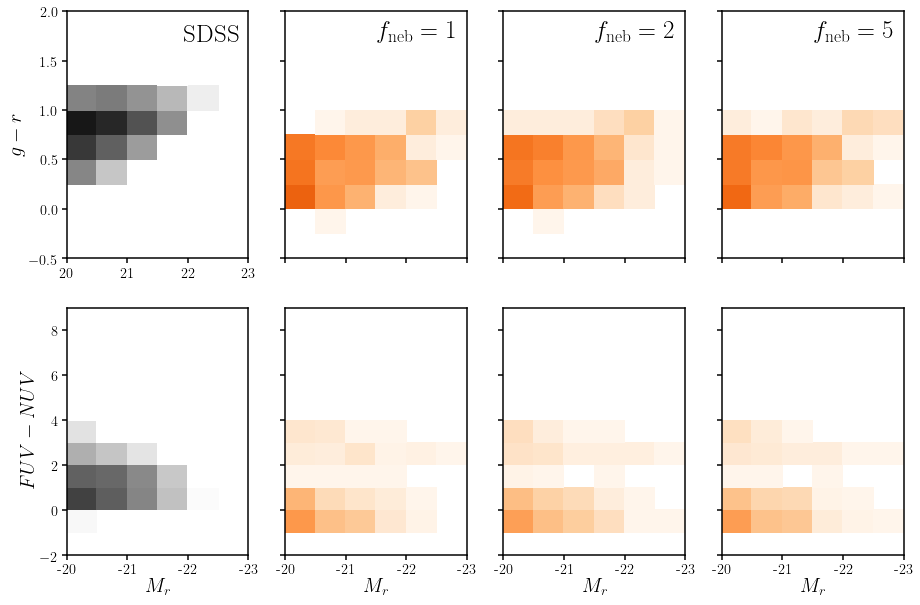

In [16]:
fnebs = [1., 2., 5.]
fig = plt.figure(figsize=(15,10))

sub = fig.add_subplot(241)
sub.pcolormesh(Rmag_edges, GR_edges, 0.5 * np.sum(x_obs, axis=2).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.text(0.95, 0.95, r'SDSS', ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_ylabel(r'$g - r$', fontsize=20) 
#sub.set_ylabel(r'$\log (H_\alpha/H_\beta)/(H_\alpha/H_\beta)_I$', fontsize=20) 
sub.set_ylim(ranges[1]) 

sub = fig.add_subplot(245)
sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_obs, axis=1).T,
        vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Greys')
sub.set_xlabel(r'$M_r$', fontsize=20) 
sub.set_xlim(20., 23) 
sub.set_xticks([20., 21., 22., 23]) 
sub.set_xticklabels([-20, -21, -22, -23]) 
sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
sub.set_ylim(ranges[2]) 

for i, fneb in enumerate(fnebs):
    sub = fig.add_subplot(2,4,i+2)
    x_mod = sim_observables_tauV_delta_fneb(1., 1., fneb, sim='simba')
    sub.pcolormesh(Rmag_edges, GR_edges, dfuvnuv * np.sum(x_mod, axis=2).T, 
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.text(0.95, 0.95, r'$f_{\rm neb}=%.f$' % fneb, ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    sub.set_yticklabels([])
    sub.set_ylim(ranges[1]) 

    sub = fig.add_subplot(2,4,i+6)
    sub.pcolormesh(Rmag_edges, fuvnuv_edges, 0.2 * np.sum(x_mod, axis=1).T,
            vmin=1e-5, vmax=1e-2, norm=mpl.colors.LogNorm(), cmap='Oranges')
    sub.set_xlabel(r'$M_r$', fontsize=20) 
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    sub.set_ylim(ranges[2]) 
    sub.set_yticklabels([])